In [101]:
import numpy as np
import random
import time
from IPython.display import clear_output

class TownBoard:
    """
    Initializes a board of roads, houses, and trees

    Attributes:
    ------------
    size : int, the length and width of the board
    num_houses : int, number of houses that will be randomly placed in the town
    grid : 2D NumPy array representing the full environment 
    cell_types : Dictionary of ints (cell types) to dictionaries of each type's name, emoji, and flammability
    warning_active : boolean of whether the warning is acitve
    house_paths : list of paths from houses to road exit
    cars : list of active car lists
    car_times : list of time each car took to evacuate
    
    Methods:
    ------------
    __init__(self, size, num_houses):
        Initializes an empty board
        Defines cell types and attributes

    generate_town():
        Fills the board with trees, roads in a cross through the board, 
        a warning tower in the top left, and houses in random positions, 
        connected to the central road by another road

    _create_crossroads():
        Creates a + shaped cross in the middle of the board

    _connect_to_cross(x,y):
        Create road path from a house at (x,y) to the nearest crossroad

    assign_cars():
        Place cars on road tiles adjacent to houses and set their paths

    move_cars():
        Move each car along their designated path out

    display():
        Visual display of the simulation board with legend
    """
    def __init__(self, size=20, num_houses=10):
        """
        Initializes an empty board
        Defines cell types and attributes

        Parameters:
        size : int, the length and width of the board, default 20
        num_houses : int, number of houses that will be randomly placed in the town, default 10
        """
        self.size = size
        self.num_houses = num_houses
        self.grid = np.zeros((size, size), dtype=int)

        # Define what each grid value represents
        self.cell_types = {
            0: {'name': 'tree', 'emoji': '🌲', 'flammable': True},
            1: {'name': 'house', 'emoji': '🏠', 'flammable': True},
            2: {'name': 'fire', 'emoji': '🔥', 'flammable': False},
            3: {'name': 'burned', 'emoji': '🪵', 'flammable': False},
            4: {'name': 'road', 'emoji': '⬜', 'flammable': False},
            5: {'name': 'tower', 'emoji': '🗼', 'flammable': False},
            6: {'name': 'car', 'emoji': '🚗', 'flammable': False},
            13: {'name':'tornado','emoji':'🌪️','flammable':False},
            14: {'name':'destroyed', 'emoji': '🪵', 'flammable': False}
        }

        # Simulation flags and tracking lists
        self.warning_active = False
        self.house_paths = []  # Path from house to road exit
        self.cars = []         # Active car agents
        self.car_times = []    # Time each car took to evacuate

    def generate_town(self):
        """Fills the board with trees, roads in a cross through the board, 
        a warning tower in the top left, and houses in random positions, 
        connected to the central road by another road"""
        self.grid.fill(0)  # Fill grid with trees
        self._create_crossroads()  # Add main roads
        self.grid[1][1] = 5  # Place warning tower at top-left corner

        # Place houses and generate evacuation paths
        self.house_positions = []
        placed = 0
        while placed < self.num_houses:
            x, y = random.randint(1, self.size - 2), random.randint(1, self.size - 2)
            if self.grid[y][x] == 0:
                self.grid[y][x] = 1
                path = self._connect_to_cross(x, y)  # Connect house to road
                if path:
                    self.house_positions.append((x, y))
                    self.house_paths.append(path)
                    placed += 1

    def _create_crossroads(self):
        """Creates a + shaped cross in the middle of the board"""
        mid = self.size // 2
        for i in range(self.size):
            self.grid[mid][i] = 4  # Horizontal
            self.grid[i][mid] = 4  # Vertical
    
    def _connect_to_cross(self, x, y):
        """ Create road path from a house at (x,y) to the nearest crossroad
        Parameters:
        x,y : int, coordinates of the house
        """
        mid = self.size // 2
        path = []
        cx, cy = x, y

        # Move horizontally to center
        while cx != mid:
            cx += 1 if mid > cx else -1
            if self.grid[cy][cx] == 0:
                self.grid[cy][cx] = 4
            path.append((cx, cy))

        # Move vertically to center
        while cy != mid:
            cy += 1 if mid > cy else -1
            if self.grid[cy][cx] == 0:
                self.grid[cy][cx] = 4
            path.append((cx, cy))

        # From center, randomly pick an edge as the road exit
        exits = [(0, cy), (self.size - 1, cy), (cx, 0), (cx, self.size - 1)]
        ex, ey = random.choice(exits)

        # Extend road horizontally to edge
        while cx != ex:
            cx += 1 if ex > cx else -1
            if self.grid[cy][cx] == 0:
                self.grid[cy][cx] = 4
            path.append((cx, cy))

        # Extend road vertically to edge
        while cy != ey:
            cy += 1 if ey > cy else -1
            if self.grid[cy][cx] == 0:
                self.grid[cy][cx] = 4
            path.append((cx, cy))

        return path

    def assign_cars(self):
        """Place cars on road tiles adjacent to houses and set their path"""
        for path in self.house_paths:
            if not path:
                continue
            start = path[0]
            x, y = start
            delay = 0
            self.cars.append([x, y, path[:], delay, 0])  # (x, y, path, delay, steps)

    def move_cars(self):
        """Move each car along their designated path out"""
        updated_cars = []
        for x, y, path, delay, steps in self.cars:
            if delay > 0: #unimplemented
                updated_cars.append([x, y, path, delay - 1, steps + 1])
                continue
            self.grid[y][x] = 4  # Leave behind a road
            if path: #if there is steps left, remove latest step and go there
                x, y = path.pop(0)
                if 0 <= x < self.size and 0 <= y < self.size:
                    self.grid[y][x] = 6 # Move car forward
                    updated_cars.append([x, y, path, 0, steps + 1])
            else:
                self.car_times.append(steps) #Car finished
        self.cars = updated_cars

    def display(self):
        """Visual display of the simulation board with legend"""
        clear_output(wait=True)
        if self.warning_active:
            print("\n🚨 TORNADO WARNING 🚨\n🚨 WEE-OO WEE-OO 🚨\n")
        for row in self.grid:
            print(' '.join(self.cell_types[cell]['emoji'] for cell in row))
        print("\nLegend: 🌲 Tree | 🏠 House | 🌪️ Tornado | 🪵 Destroyed Area | ⬜ Road | 🗼 Tower | 🚗 Car")

In [102]:
class TornadoSimulator:
    """
    Simulates a tornado moving through the town
    
    Attributes:
    ----------
    board : TownBoard class the simulation is over
    time_step : int, number of steps passed
    path : list of the coordinates the tornado has moved through
    under : dictionary of cells the tornado passed over
    destroyed_cars : list of cars destroyed by the tornado

    Methods:
    ----------
    __init__(town_board):
        Initializes the simulator
        Includes starting the tornado on a random edge cell
        and starting the warning for evacuation.

    move():
        Moves the tornado randomly, destroys non-road cells
        under the tornado, and checks if the tornado hits a car.
        
    hit_check():
        Checks whether the tornado is on any cars and destroys those cars
    
    simulate(steps,delay,display):
        Run complete tornado simulation by displaying the board and
        moving each time step
    """
    def __init__(self, town_board):
        """
        Initializes the simulator
        Includes starting the tornado on a random edge cell
        and starting the warning for evacuation.
        
        Paramaters:
        town_board : TownBoard class the simulation is on
        """
        #sets initial attributes
        self.board = town_board
        self.time_step = 0
        self.destroyed_cars=[]

        #randomly picks coordinates among the cells on the edges of the board
        x, y = random.randint(0, len(self.board.grid)-1), random.randint(0, len(self.board.grid)-1)
        starts=[(0,y),(x,0),(len(self.board.grid)-1,y),(x,len(self.board.grid)-1)]
        start=starts[np.random.choice(len(starts))]
        #records what's already there and sets the tornado
        self.under={start:self.board.grid[start]}
        self.board.grid[start]=13
        #adds the coordinates to the path
        self.path = [start]

        #starts evacuation
        self.board.warning_active = True
        self.board.assign_cars()
        
    
    def move(self):
        """
        Moves the tornado randomly, destroys non-road cells
        under the tornado, and checks if the tornado hits a car.
        """
        #gets last tornado coordinates
        x,y=self.path[-1]

        #sets what's under the tornado to destroyed or back to a road
        previous=self.under[(x,y)]
        if previous!=4:
            self.board.grid[(x,y)]=14
        else:
            self.board.grid[(x,y)]=4

        #Makes a weighted list of spaces in a 3x3 area around the tornado where
        #it could move, discouraging looping back on itself or staying still
        options=[]
        for dx in [-1, 0, 1]:
            for dy in [-1, 0, 1]:
                nx, ny = x+dx, y+dy
                if dx == 0 and dy == 0:
                    for k in range(2):
                        options.append((nx,ny))
                if 0<=nx<len(self.board.grid) and 0<=ny<len(self.board.grid):
                    if (nx,ny) in self.path:
                        options.append((nx,ny))
                    else:
                        for k in range(3):
                            options.append((nx,ny))  
        
        #Randomly picks the cell to move to
        new=options[np.random.choice(len(options))]
        
        #Adds what's already there before the tornado moves on
        if self.board.grid[new]==6:
            self.under[new]=4 #cars are ignored and interpreted as roads
        else:
            self.under[new]=self.board.grid[new]

        #sets the cell to the tornado and adds it to the path
        self.board.grid[new]=13
        self.path.append(new)
        #checks whether the tornado is on any cars
        self.hit_check()
        self.time_step += 1

        
    def hit_check(self):
        """
        Checks whether the tornado is on any cars and destroys those cars
        """
        cars=[]
        for car in self.board.cars:
            #checks if each car's coordinates are the same as the tornado's
            if car[0]==self.path[-1][0] and car[1]==self.path[-1][1]:
                #records any destroyed cars and sets their cell to road (just in case)
                self.destroyed_cars.append(car)
                self.board.grid[(car[0],car[1])]=4
            else:
                cars.append(car)
                #cars that aren't destroyed are recorded and set
        self.board.cars=cars
                
    
    def simulate(self, steps=25, delay=0.1, display=True):
        """
        Run complete tornado simulation by displaying the board and
        moving each time step

        Parameters:
        steps : int, number of steps the simulation loops over, default 25
        delay : float, time (in sec) each step is displayed for, default 0.1
        display : boolean, whether the board is displayed each step of not, default True
        """
        for t in range(steps):
            #each step, displays the board, moves the car, then tornado
            if display==True:
                self.board.display()
            self.board.move_cars()
            self.move()
            #stops on the step for the delay length
            time.sleep(delay)

In [98]:
#makes a 20x20 town
town = TownBoard(20)
town.generate_town()
    
# Simulate tornado going through the town
disaster = TornadoSimulator(town)
disaster.simulate(steps=30, delay=0.4)
print("\nSimulation complete")
#shows how many and when each car made it off the board
for i, t in enumerate(town.car_times):
    print(f"Car {i+1} evacuated in {t} minutes")
if town.car_times:
    print(f"Total evacuation time: {max(town.car_times)} minutes")
#shows how many cars were destroyed by the tornado
print(len(disaster.destroyed_cars),'car(s) destroyed')


🚨 TORNADO WARNING 🚨
🚨 WEE-OO WEE-OO 🚨

🌲 🌲 🌲 🌲 🌲 🌲 🌲 🌲 🌲 🌲 ⬜ 🌲 🌲 🌲 🌲 🌲 🌲 🌲 🌲 🌲
🌲 🗼 🌲 🌲 🌲 🌲 🌲 🌲 🌲 🌲 ⬜ 🌲 🌲 🌲 🌲 🌲 🌲 🌲 🌲 🌲
🌲 🌲 🌲 🌲 🌲 🌲 🌲 🌲 🌲 🌲 ⬜ ⬜ ⬜ 🏠 🌲 🌲 🌲 🌲 🌲 🌲
🌲 🌲 🌲 🌲 🌲 🌲 🌲 🌲 🌲 🌲 ⬜ 🌲 🌲 🌲 🌲 🌲 🌲 🌲 🌲 🌲
🌲 🌲 🌲 🌲 🌲 🌲 🌲 🌲 🌲 🌲 ⬜ 🌲 🌲 🌲 🌲 🌲 🌲 🌲 🌲 🌲
🌲 🌲 🌲 🌲 🌲 🌲 🌲 🌲 🌲 🌲 ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ 🏠 🌲 🌲 🌲
🌲 🌲 🌲 🌲 🌲 🌲 🌲 🌲 🌲 🌲 ⬜ 🌲 🌲 🌲 🌲 🌲 🌲 🌲 🌲 🌲
🌲 🌲 🌲 🌲 🏠 ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ 🌲 🌲 🌲 🌲 🌲 🌲 🌲 🌲 🌲
🌲 🌲 🌲 🌲 🌲 🌲 🌲 🌲 🌲 🏠 ⬜ 🌲 🌲 🌲 🌲 🌲 🌲 🌲 🌲 🌲
🌲 🌲 🌲 🌲 🌲 🏠 ⬜ ⬜ ⬜ ⬜ ⬜ 🌲 🌲 🌲 🌲 🌲 🌲 🌲 🌲 🌲
⬜ ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ ⬜
🌲 🌲 🌲 🌲 🌲 🌲 🏠 ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ 🏠 🌲 🌲
🌲 🌲 🌲 🌲 🌲 🪵 🌲 🪵 🪵 🌲 ⬜ 🌲 🌲 🌲 🌲 🌲 🌲 🌲 🌲 🌲
🌲 🌲 🌲 🌲 🪵 🪵 🪵 🪵 🪵 🌪️ ⬜ 🌲 🌲 🌲 🌲 🌲 🌲 🌲 🌲 🌲
🌲 🌲 🌲 🌲 🌲 🪵 🪵 🪵 🪵 🌲 ⬜ 🌲 🌲 🌲 🌲 🌲 🌲 🌲 🌲 🌲
🌲 🌲 🌲 🌲 🪵 🌲 🌲 🌲 🌲 🌲 ⬜ 🌲 🌲 🌲 🌲 🌲 🌲 🌲 🌲 🌲
🌲 🏠 ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ 🌲 🌲 🌲 🌲 🌲 🌲 🌲 🌲 🌲
🌲 🌲 🪵 🪵 🌲 🌲 🌲 🌲 🌲 🌲 ⬜ 🌲 🌲 🌲 🌲 🌲 🌲 🌲 🌲 🌲
🌲 🪵 🪵 🌲 🌲 🌲 🌲 🏠 ⬜ ⬜ ⬜ ⬜ ⬜ 🏠 🌲 🌲 🌲 🌲 🌲 🌲
🪵 🌲 🌲 🌲 🌲 🌲 🌲 🌲 🌲 🌲 ⬜ 🌲 🌲 🌲 🌲 🌲 🌲 🌲 🌲 🌲

Legend: 🌲 Tree | 🏠 House | 🌪️ Tornado | 🪵 Destroyed Area | ⬜ Road | 🗼 Tower | 🚗 Car

Simulation complete
Car 1 evacuated in 12 minutes
Car 2 evacuated in 14 m

In [93]:
#Simulating 1000 times
evacuation_time=[]
cars_destroyed=[]
for i in range(1000):
    town = TownBoard(20)
    town.generate_town()
    disaster = TornadoSimulator(town)
    disaster.simulate(steps=30, delay=0,display=False)
    evacuation_time.append(max(town.car_times))
    cars_destroyed.append(len(disaster.destroyed_cars))

In [94]:
times=0
destroyed=0
for t in evacuation_time:
    times+=t
for cars in cars_destroyed:
    destroyed+=cars
print(times/1000)
print(destroyed/1000)

24.217
0.16


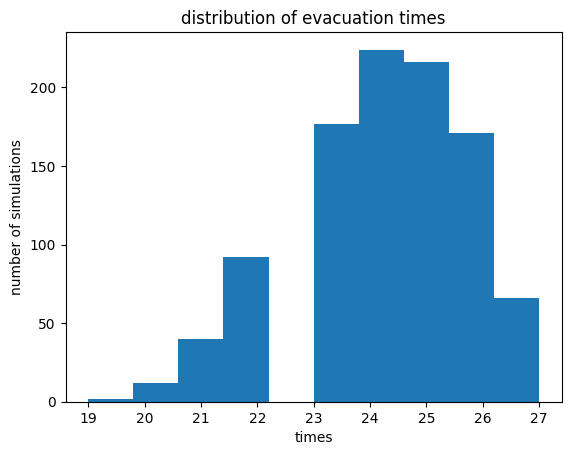

In [99]:
import matplotlib.pyplot as plt
plt.hist(evacuation_time)
plt.xlabel('times')
plt.ylabel('number of simulations')
plt.title('distribution of evacuation times');